In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from mahalanobis import MahalanobisClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
valid = pd.read_csv("valid_set.csv")
test = pd.read_csv("test_set.csv")

In [3]:
valid_samps = valid.drop(["aerosol_type", "date"], axis=1)
valid_labels = valid["aerosol_type"]

## Load all models

In [4]:
mdc = pickle.load(open('models/mdc_pickle', 'rb'))
knn_tuned = pickle.load(open('models/knn_tuned_pickle', 'rb'))
gnb_tuned = pickle.load(open('models/gnb_tuned_pickle', 'rb'))

In [5]:
preds_mdc = mdc.predict_class(valid_samps)
preds_knn = knn_tuned.predict(valid_samps)
preds_gnb = gnb_tuned.predict(valid_samps)

## Model Performance

### A. Accuracy, Precision, Recall, and F1 Scores 

In [6]:
def get_performance_metrics(predictions):
    
    ave_params = ["macro", "weighted"]
    precision_list = [precision_score(valid_labels, predictions, average=i) for i in ave_params]
    recall_list = [recall_score(valid_labels, predictions, average=i) for i in ave_params]
    f1_list = [f1_score(valid_labels, predictions, average=i) for i in ave_params]
    
    return [accuracy_score(valid_labels, predictions)] + precision_list + recall_list + f1_list

In [7]:
# Collate metrics in one dataframe
metrics_table = pd.DataFrame({
    "MDC": get_performance_metrics(preds_mdc),
    "KNN-Tuned": get_performance_metrics(preds_knn),
    "NB-Tuned": get_performance_metrics(preds_gnb)
}).transpose()

In [8]:
# Rename columns
metrics_table.columns = [
    "Accuracy", 
    "Precision (Macro)", "Precision (Weighted)", 
    "Recall (Macro)", "Recall (Weighted)", 
    "F1 Score (Macro)", "F1 Score (Weighted)"
]

In [9]:
# Display table of performance metrics
metrics_table

,Accuracy,Precision (Macro),Precision (Weighted),Recall (Macro),Recall (Weighted),F1 Score (Macro),F1 Score (Weighted)
MDC,0.811612,0.805654,0.819687,0.795800,0.811612,0.799225,0.813971
KNN-Tuned,0.981415,0.978944,0.981601,0.982072,0.981415,0.980385,0.981423
NB-Tuned,0.727747,0.695115,0.733970,0.710700,0.727747,0.694881,0.723100


In [10]:
# Export results as CSV
metrics_table.to_csv("tables/metrics_table.csv", index=True)

### B. Confusion Matrix

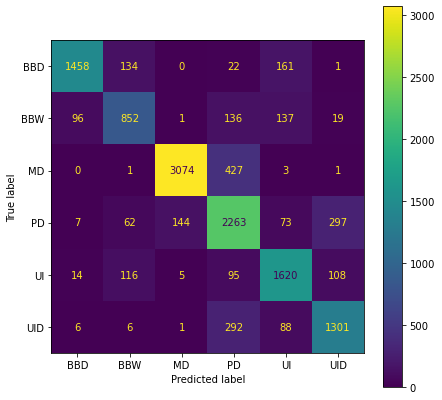

In [11]:
# Confusion matrix visualization for Mahalanobis Distance Classifier (MDC) results
cm_mdc = confusion_matrix(valid_labels, preds_mdc)
cm_display = ConfusionMatrixDisplay(cm_mdc, display_labels=np.unique(valid_labels))
fig, ax = plt.subplots(figsize=(7,7))
cm_display.plot(ax=ax)

fig.savefig('figures/confusion_matrix_mdc.png', dpi=300)

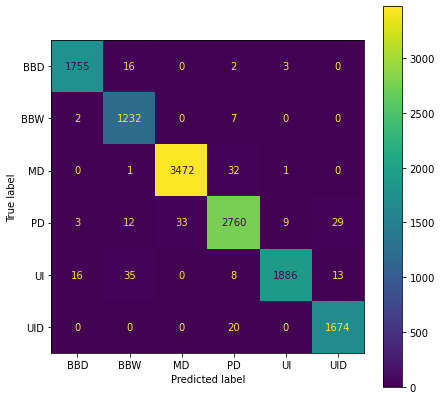

In [12]:
# Confusion matrix visualization for k-Nearest Neighbors (KNN) results
cm_knn = confusion_matrix(valid_labels, preds_knn)
cm_display = ConfusionMatrixDisplay(cm_knn, display_labels=np.unique(valid_labels))
fig, ax = plt.subplots(figsize=(7,7))
cm_display.plot(ax=ax)

fig.savefig('figures/confusion_matrix_knn.png', dpi=300)

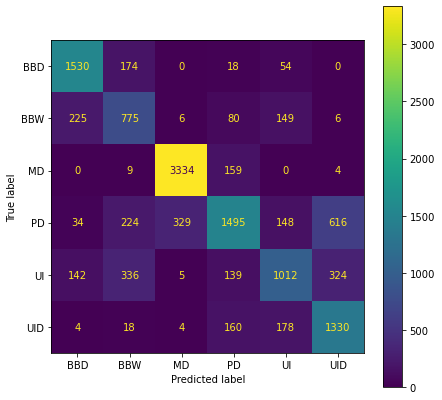

In [13]:
# Confusion matrix visualization for Naive Bayes Classifier (NB) results
cm_gnb = confusion_matrix(valid_labels, preds_gnb)
cm_display = ConfusionMatrixDisplay(cm_gnb, display_labels=np.unique(valid_labels))
fig, ax = plt.subplots(figsize=(7,7))
cm_display.plot(ax=ax)

fig.savefig('figures/confusion_matrix_gnb.png', dpi=300)

## Predicting on Test Set

In [14]:
# Best model is chosen to be KNN
preds_on_test = knn_tuned.predict(test.drop(["date"], axis=1))

# Append predictions to test set as first column
test.insert(0, "aerosol_type", preds_on_test)

In [15]:
# Export appended test set as CSV
test.to_csv("tables/test_new.csv", index=False)